In [ ]:
'''
    (a) CNN for lunar crater image classification
    (b) Version number: 1
    (c) Autors: davribsan
    (d) Date of initializaition: 09/10/24
    (e) Description of the program: 
        This program implements a complete workflow for lunar crater image classification using a convolutional 
        neural network (CNN), including model training, performance evaluation, and prediction on a test set.  

    (f) Sources:
        - Machine Learning course contents from IST 
        - Voice and Image Digital Processing course contents from University of Malaga

    g) Range of validity expected of the parameters and range tested:

        - Expected and Tested: 48*48 pixel grayscale images 

    (h) Inputs:

        lower_threshold: lower pixel intensity level threshold below which it is considered to belong to an crater edge
        upper_threshold: upper pixel intensity level threshold above which it is considered to belong to an crater edge
        n_epochs_CNN: number of epochs for training without extra data
        n_epochs_CNN_extra:  number of epochs for training with extra data
        lr_CNN: initial learning rate for training without extra data 
        lr_CNN_extra: initial learning rate for training without extra data 
        step_size_CNN: number of epochs after which the learning rate must be updated for the dataset without extra data
        step_size_CNN_extra: number of epochs after which the learning rate must be updated for the dataset with extra data
        batch_size_CNN: number of samples per group the net uses to update the gradient for the dataset without extra data
        batch_size_CNN_extra: number of samples per group the net uses to update the gradient for the dataset with extra data
        gamma_CNN: factor that multiplies the learning rate when updating for the dataset without extra data 
        gamma_CNN_extra: factor that multiplies the learning rate when updating for the dataset with extra data 
        momentum_CNN: parameter that speeds up the convergence of the net for the dataset without extra data  
        momentum_CNN_extra: parameter that speeds up the convergence of the net for the dataset with extra data  
        prob_thresh: minimum predicted probability that a sample must reach to be considered as belonging to a certain class in the extra dataset
        
    (i) Outputs:

        Loss and accuracy evolution of the model without extra data 
        F1 Score of the model without extra data 
        Confusion matrix of the model without extra data 
        Loss and accuracy evolution of the model with extra data 
        F1 Score of the model with extra data 
        Confusion matrix of the model with extra data
        Predictions on the test set 

    (j) List of dependencies:
            - NumPy: numerical computations and array manipulation
            - Matplotlib: visualization of images and training curves
            - scikit-learn: dataset splitting, F1 score, and confusion matrix
            - PyTorch: deep learning framework used for tensor operations, automatic differentiation, and building/training neural network models.
            - imbalanced-learn (imblearn): Random Over Sampling (ROS) for class balancing

    (k) Software version: Python 3.12.4
    '''

# Inputs

The Inputs section establishes all the foundational elements required for the project. It includes importing essential libraries, loading the dataset, and defining key parameters for the neural network.

## Libraries

This subsection imports all the Python libraries required for the notebook.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from imblearn.over_sampling import RandomOverSampler

## Neural network parameters

This section defines the key hyperparameters and configuration settings used to build and train the neural network. These parameters control model architecture, learning behavior, and optimization strategy.

In [ ]:
lower_threshold = 50
upper_threshold = 200
n_epochs_CNN = 60
n_epochs_CNN_extra = 60
lr_CNN = 0.01
lr_CNN_extra = 0.001
step_size_CNN = 40
step_size_CNN_extra = 10
batch_size_CNN = 64
batch_size_CNN_extra = 64
gamma_CNN = 0.1
gamma_CNN_extra = 0.1
momentum_CNN = 0.9
momentum_CNN_extra = 0.9
prob_thresh = 0.95

## Data

This section loads the dataset used throughout the notebook. It includes reading the data from its source, validating its structure, and performing initial inspections.

In [8]:
X_train = np.load('Xtrain1.npy')
y_train = np.load('Ytrain1.npy')
X_test = np.load('Xtest1.npy')
X_train_extra = np.load('Xtrain1_extra.npy')

print(f'Number of images in the training set: {X_train.shape[0]}')
print(f'Number of images in the test set: {X_test.shape[0]}')
print(f'Image size: {int(np.sqrt(X_test.shape[1]))}*{int(np.sqrt(X_test.shape[1]))} pixels')

Number of images in the training set: 2783
Number of images in the test set: 696
Image size: 48*48 pixels


# Data Pre-Treatment

The Data Pre-Treatment section performs all necessary preprocessing steps to prepare the dataset for model training and evaluation. It includes binarization of both labeled and unlabeled images to emphasize relevant features, such as crater boundaries, while simplifying the visual complexity of the input. Additionally, the section addresses class imbalance by applying Random Oversampling to underrepresented classes, ensuring that the dataset provides sufficient examples for the model to learn effectively. Finally, verification of class distributions confirms the effectiveness of these preprocessing steps, establishing a clean, balanced, and well-structured dataset for subsequent analysis and model development.

## Binarization of Training Data

This step performs the initial preprocessing of the raw images. Because crater edges correspond to sharp changes in pixel intensity, binarization helps emphasize these boundaries by converting the image into a simplified black-and-white representation. Highlighting only the significant intensity transitions while setting all other pixels to 0 reduces visual complexity. As a result, the classification task is simplified: instead of interpreting full grayscale textures, the model can focus on detecting the presence or absence of characteristic crater boundaries.

In [ ]:
# Reshape the flat arrays into 48x48 pixel images
im = X_train.reshape(X_train.shape[0],48,48)    

# Copy the images to a new array not to affect the original
new = im.copy() 

# Binarize the images to facilitate the craters detection
for sample in range(im.shape[0]):

  # Outstanding boundaries
  for i in range(im.shape[1]):
      for j in range(im.shape[2]):
          if (im[sample][i][j] > upper_threshold) | (im[sample][i][j] < lower_threshold):
              new[sample][i][j] = 255
          else:
              new[sample][i][j] = 0

  # Removing isolated pixels
  for i in range(new.shape[1]):
      for j in range(new.shape[2]):
          if new[sample][i][j] == 255:
              if (i>0) and (j>0) and (i<new.shape[1]-1) and (j<new.shape[2]-1):
                  if ((new[sample][i-1][j]==0) and (new[sample][i+1][j]==0) and
                      (new[sample][i][j-1]==0) and (new[sample][i][j+1]==0) and
                      (new[sample][i-1][j-1]==0) and (new[sample][i-1][j+1]==0) and
                      (new[sample][i+1][j-1]==0) and (new[sample][i+1][j+1]==0)):

                        new[sample][i][j] = 0

# Convert each image into a 1D array for input to the neural network
X_train_processed = new.reshape(new.shape[0],48*48)

## Binarization of Extra Data

This step performs initial preprocessing on the extra dataset, where labels are not provided. Similar to the training data, binarization highlights sharp changes in pixel intensity, emphasizing potential crater boundaries while setting all other pixels to 0. This simplification allows the model to focus on detecting the presence of boundary patterns, even in unlabeled images, preparing the data for prediction or further analysis.

In [11]:
# Reshape the flat arrays into 48x48 pixel images
im = X_train_extra.reshape(X_train_extra.shape[0],48,48)   

# Copy the images to a new array not to affect the original
new = im.copy() 

# Binarize the images to facilitate the craters detection
upper_threshold = 200
lower_threshold = 50
for sample in range(im.shape[0]):

  # Outstanding boundaries
  for i in range(im.shape[1]):
      for j in range(im.shape[2]):
          if (im[sample][i][j] > upper_threshold) | (im[sample][i][j] < lower_threshold):
              new[sample][i][j] = 255
          else:
              new[sample][i][j] = 0

  # Removing isolated pixels
  for i in range(new.shape[1]):
      for j in range(new.shape[2]):
          if new[sample][i][j] == 255:
              if (i>0) and (j>0) and (i<new.shape[1]-1) and (j<new.shape[2]-1):
                  if ((new[sample][i-1][j]==0) and (new[sample][i+1][j]==0) and
                      (new[sample][i][j-1]==0) and (new[sample][i][j+1]==0) and
                      (new[sample][i-1][j-1]==0) and (new[sample][i-1][j+1]==0) and
                      (new[sample][i+1][j-1]==0) and (new[sample][i+1][j+1]==0)):

                        new[sample][i][j] = 0
                    
# Convert each image into a 1D array for input to the neural network
X_extra_processed = new.reshape(new.shape[0],48*48)

## Data Inbalance

This subsection addresses the imbalance in the dataset, where certain classes (e.g., images with craters) are underrepresented compared to others (e.g., images without craters). Class imbalance can negatively affect model training, causing the model to become biased toward the majority class and underperform on the minority class.

### Verify the Imbalance in the Dataset

This subsection performs an analysis to confirm and quantify class imbalance in the dataset. By examining the distribution of class labels, it can be identified whether certain classes (e.g., images with craters) are underrepresented.

In [12]:
print("Number of training samples with class 0:", np.sum(y_train==0))
print("Number of training samples with class 1:", np.sum(y_train==1))
print("Fraction of training samples in class 0 relative to class 1:", np.sum(y_train==0)/np.sum(y_train==1))

Number of training samples with class 0: 1006
Number of training samples with class 1: 1777
Fraction of training samples in class 0 relative to class 1: 0.566122678671919


### Random Oversampling

This subsection handles data imbalance by randomly replicating samples from the minority class (class 0). This approach could help the model learn meaningful features, reduces bias toward the majority class, and improves generalization performance.

In [13]:
# Create the oversampling model
ros = RandomOverSampler(random_state=None)

# Split the training set into training and validation sets
X_train_ROS, X_val_2, y_train_ROS, y_val_2 = train_test_split(X_train_processed, y_train, test_size=0.2)

# Apply the oversampling model 
X_train_ROS, y_train_ROS = ros.fit_resample(X_train_ROS, y_train_ROS)

# Verification
print("Number of training samples with class 0 after ROS:", np.sum(y_train_ROS==0))
print("Number of training samples with class 1 after ROS:", np.sum(y_train_ROS==1))

Number of training samples with class 0 after ROS: 1406
Number of training samples with class 1 after ROS: 1406


# CNN: LeNeT    

This section introduces the convolutional neural network (CNN) employed for the crater classification task. The model is implemented following a compact and efficient design inspired by LeNet, chosen for its suitability for small grayscale images and its low computational cost.

## Preprare Data to use in the NN

This subsection formats the datasets for input into the convolutional neural network (CNN). The data is converted into tensors and structured according to the network’s input requirements, ensuring compatibility with the model architecture.

In [ ]:
# Convert the linear arrays into 48*48 pixel images
X_train_balanced = X_train_ROS.reshape(X_train_ROS.shape[0],48,48)
X_val_balanced = X_val_2.reshape(X_val_2.shape[0],48,48)

# Normalize images (Tensors only admit normalized float data)
X_train_normalized = (X_train_balanced / 255.0).astype(np.float32)  
X_val_normalized = (X_val_balanced / 255.0).astype(np.float32)

# Convert images matrixes into tensors  
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_normalized, dtype=torch.float32)

# Increase the rank of the tensor (dimension) to use the number of channels as input of the CNN
X_train_tensor = X_train_tensor.unsqueeze(1)  
X_val_tensor = X_val_tensor.unsqueeze(1)

# Convert the labels into tensors 
y_train_tensor = torch.tensor(y_train_ROS, dtype=torch.long) # Long because the labels are int  
y_val_tensor = torch.tensor(y_val_2, dtype=torch.long)

# Create a unique object with data and labels 
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Prepare data loaders to iterate over datasets in batches
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size_CNN, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size_CNN, shuffle=False) # To maintain the same referenc at any epoch

## Net Architecture

This subsection provides an overview of the convolutional neural network (CNN) employed for crater detection. It introduces the network’s design and role in processing preprocessed image data. The subsequent subsections define the detailed network implementation and specify the training configuration, outlining how the model is structured and optimized to learn meaningful features effectively.

### Definition of the Net

This subsection specifies the implementation of the CNN, detailing each layer and its parameters. The network consists of multiple convolutional layers followed by max-pooling layers to extract hierarchical features from input images, and fully connected layers to perform classification. Activation functions are applied after each convolutional and intermediate fully connected layer to introduce non-linearity. The output layer generates class scores suitable for the chosen loss function.

In [15]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
         # Layers creation
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)      # Padding = kernel_size//2
        self.mp1 = nn.MaxPool2d(2)                      # Reduce the dimensions of the layer by getting the important value
        self.conv2 = nn.Conv2d(6, 18, 5, padding=2)
        self.mp2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(18, 126, 3, padding=1)
        self.fc1 = nn.Linear(12*12*126, 256)            # Reduce the dimensions of the features
        self.fc2 = nn.Linear(256, 2)                    # Output layer

    def forward(self, x):
       # Backpropagation of the error
        x = F.relu(self.conv1(x))                       # Apply the activation funtion
        x = self.mp1(x)                                 # Apply max pooling
        x = F.relu(self.conv2(x))
        x = self.mp2(x)
        x = F.relu(self.conv3(x))
        x = x.view(-1, 12*12*126)                       # Faltten the 3D output from previous layer to to feed it into the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)                                 # No activation function is needed since CrossEntropyLoss already includes softmax 
        return x                                        # Return the final predictions

### Training setup

This subsection defines the training configuration for the CNN. The model is instantiated using the LeNet architecture, designed to extract hierarchical features from input images. CrossEntropyLoss is employed as the loss function, suitable for multi-class classification without requiring one-hot encoding. The Stochastic Gradient Descent (SGD) optimizer with momentum is used to update model weights efficiently and accelerate convergence. Additionally, a StepLR learning rate scheduler reduces the learning rate periodically, improving training stability and preventing overshooting during optimization. This setup ensures reproducible and effective training while maximizing the model’s ability to generalize from the preprocessed dataset.

In [ ]:
# Create the net 
CNN_model = LeNet()

# Define the loss function
criterion = nn.CrossEntropyLoss() # One-hot encoding is not necessary because CrossEntropyLoss expects a int label

# Optimizer to adjust the weights during the training with an acceleration strategy  
optimizer = optim.SGD(CNN_model.parameters(), lr=lr_CNN, momentum=momentum_CNN) 

# Learning rate scheduler to reduce the learning rate every few epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size_CNN, gamma=gamma_CNN)

# Verify the model 
CNN_model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 18, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (mp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(18, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=18144, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=2, bias=True)
)

## Training

This subsection describes the training process of the convolutional neural network (CNN) on the preprocessed dataset. The model is trained iteratively over multiple epochs, performing forward passes to generate predictions, computing the loss, and updating weights via backpropagation and optimization. Training and validation accuracy and loss are recorded at each epoch to monitor performance, while a learning rate scheduler adjusts the learning rate periodically to enhance convergence.

In [17]:
train_accuracy_1 = torch.zeros(n_epochs_CNN)
train_loss_1 = torch.zeros(n_epochs_CNN)
val_accuracy_1 = torch.zeros(n_epochs_CNN)
val_loss_1 = torch.zeros(n_epochs_CNN)

for epoch in range(n_epochs_CNN):

    # Train
    CNN_model.train()

    # Loss of the epoch
    running_loss = 0.0 

    # Accuracy of the epoch
    running_acc = 0.0 

    total = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        
        total += labels.shape[0]
       
        # Gradients ainitialization
        optimizer.zero_grad()

        # Forward-pass
        outputs = CNN_model(images)

        # Loss calculation
        loss = criterion(outputs, labels) 

        # Backward pass
        loss.backward()

        # Optimization
        optimizer.step() 

        # Estatistics
        # Total loss of the current batch
        running_loss += loss.item() 

        # Select the labels with a larger number of votes                                
        _, predicted = torch.max(outputs, 1)

        # Number of correct predictions
        running_acc += torch.sum(predicted==labels)

    # Accuracy of the epoch for the training set
    train_accuracy_1[epoch] = (running_acc.float()/total).item() # because running_acc is a tensor and total an escalar

    # Loss of the epoch for the training set
    train_loss_1[epoch] = running_loss/total 
    print(f'Train      >>> Epoch {epoch} >>>>   Train Loss: {train_loss_1[epoch]}, Train Acc: {train_accuracy_1[epoch]}')

    # Model Validation
    CNN_model.eval()
    running_val_loss = 0.0  # Loss of each epoch
    running_val_acc = 0.0   # Accuracy of each epoch
    total_val = 0

    # Gradient deactivation for validation
    with torch.no_grad():  
        for i, (images, labels) in enumerate(val_loader, 0):
            total_val += labels.shape[0]

            # Forward-pass
            outputs = CNN_model(images)

            # Loss computing  
            loss = criterion(outputs, labels)  

            # Total loss of the current batch
            running_val_loss += loss.item()  

            # Select the labels with a larger number of votes                                
            _, predicted = torch.max(outputs, 1) 

             # Number of correct predictions
            running_val_acc += torch.sum(predicted == labels) 

    # Accuracy of the epoch for the training set
    val_accuracy_1[epoch] = (running_val_acc.float()/total_val).item() # because running_val_acc is a tensor and total an escalar

    # Loss of the epoch for the training set
    val_loss_1[epoch] = running_val_loss/total_val   
    print(f'Validation >>> Epoch {epoch} >>>>   Val Loss:   {val_loss_1[epoch]}, Val Acc:   {val_accuracy_1[epoch]}')

    # Learning rate of the epoch
    current_lr = optimizer.param_groups[0]['lr']  
    print(f'Current learning rate: {current_lr:.6f}')

    # Step reduction when applicable 
    scheduler.step()  

Train      >>> Epoch 0 >>>>   Train Loss: 0.010493186302483082, Train Acc: 0.5981507897377014
Validation >>> Epoch 0 >>>>   Val Loss:   0.00920281931757927, Val Acc:   0.7360861897468567
Current learning rate: 0.010000
Train      >>> Epoch 1 >>>>   Train Loss: 0.008912153542041779, Train Acc: 0.7350640296936035
Validation >>> Epoch 1 >>>>   Val Loss:   0.008231280371546745, Val Acc:   0.7648115158081055
Current learning rate: 0.010000
Train      >>> Epoch 2 >>>>   Train Loss: 0.00824450608342886, Train Acc: 0.7492887377738953
Validation >>> Epoch 2 >>>>   Val Loss:   0.010526618920266628, Val Acc:   0.6535009145736694
Current learning rate: 0.010000
Train      >>> Epoch 3 >>>>   Train Loss: 0.007924237288534641, Train Acc: 0.7571123838424683
Validation >>> Epoch 3 >>>>   Val Loss:   0.008552780374884605, Val Acc:   0.7594255208969116
Current learning rate: 0.010000
Train      >>> Epoch 4 >>>>   Train Loss: 0.007535363081842661, Train Acc: 0.7688478231430054
Validation >>> Epoch 4 >>>> 

## Use X_extra Dataset to Improve the Performance

This subsection aims to enhance the model’s performance by incorporating additional unlabelled images from the X_extra dataset.

### Extra Data Preprocessing

This subsection prepares the extra, unlabeled dataset for prediction by the previously trained CNN.

In [18]:
# Convert the linear arrays into 48*48 pixel images
X_extra_balanced = X_extra_processed.reshape(X_extra_processed.shape[0],48,48)

# Normalize images (Tensors only admit normalized float data)
X_extra_normalized = (X_extra_balanced / 255.0).astype(np.float32)  

# Convert images matrixes into tensors  
X_extra_tensor = torch.tensor(X_extra_normalized, dtype=torch.float32)

# Increase the rank of the tensor (dimension) to use the number of channels as input of the CNN
X_extra_tensor = X_extra_tensor.unsqueeze(1)  

### Find High Confidence Samples

This subsection identifies samples from the extra dataset for which the CNN produces highly confident predictions. Selecting these high-confidence samples reduces the risk of introducing noisy or incorrect labels when augmenting the training set.

In [ ]:
# Obtain the logits from the model
logits = CNN_model(X_extra_tensor)

# Obtain the probabilities
y_extra_class_prob = torch.softmax(logits, dim=1)

# Obtain the most voted class for each sample  and its probability
max_probs, y_predicted = torch.max(y_extra_class_prob, 1)

# Select those predictions that ensure a good estimation 
indexes = torch.where(max_probs > prob_thresh)[0]         # It is the same as np.where but for tensors and [0] because it returns a touple
y_extra_pred = y_predicted[indexes]

print("Number of extra samples with class 0:", torch.sum(y_extra_pred == 0).item())
print("Number of extra samples with class 1:", torch.sum(y_extra_pred == 1).item())

Number of extra samples with class 0: 391
Number of extra samples with class 1: 354


### Add Confidence Samples to the Initial Dataset

This subsection integrates the high-confidence samples into the original labeled dataset. By expanding the training set with reliable additional examples, the network has access to more diverse data, which can enhance learning and improve model performance.

In [20]:
# Convert each image into a 1D array
X_extra_processed = X_extra_processed.reshape(X_extra_processed.shape[0],48*48)

# Add the extra predicted samples 
X_train_combined = np.concatenate((X_train_processed, X_extra_processed[indexes.numpy()]), axis=0)
y_train_combined = np.concatenate((y_train, y_extra_pred.numpy()), axis=0)

# Split the training set into training and validation sets
X_train_combined, X_val_combined, y_train_combined, y_val_combined = train_test_split(X_train_combined, y_train_combined, test_size=0.2)

# Create an oversampling model
ros = RandomOverSampler(random_state=None)

# Apply the oversampling model 
X_train_combined_ROS, y_train_combined_ROS = ros.fit_resample(X_train_combined, y_train_combined)

print("Number of training samples with class 0 after adding extra samples:", np.sum(y_train_combined_ROS==0))
print("Number of training samples with class 1 after adding extra samples:", np.sum(y_train_combined_ROS==1))

Number of training samples with class 0 after adding extra samples: 1694
Number of training samples with class 1 after adding extra samples: 1694


### Adaptation for Training with X_extra

Before retraining with the augmented dataset, the images and labels obtained from the combination of the original data and the selected high-confidence samples are prepared following the same procedure used previously.

In [ ]:
# Convert the linear arrays into 48*48 pixel images
X_train_combined_balanced = X_train_combined.reshape(X_train_combined.shape[0],48,48)
X_val_combined_balanced = X_val_combined.reshape(X_val_combined.shape[0],48,48)

# Normalize images (Tensors only admit normalized float data)
X_train_combined_normalized = (X_train_combined_balanced / 255.0).astype(np.float32) 
X_val_combined_normalized = (X_val_combined_balanced / 255.0).astype(np.float32)  

# Convert images matrixes into tensors  
X_train_combined_tensor = torch.tensor(X_train_combined_normalized, dtype=torch.float32)
X_val_combined_tensor = torch.tensor(X_val_combined_normalized, dtype=torch.float32)

# Increase the rank of the tensor (dimension) to use the number of channels as input of the CNN
X_train_combined_tensor = X_train_combined_tensor.unsqueeze(1)  
X_val_combined_tensor = X_val_combined_tensor.unsqueeze(1)  

# Convert the labels into tensors 
y_train_combined_tensor = torch.tensor(y_train_combined, dtype=torch.long)
y_val_combined_tensor = torch.tensor(y_val_combined, dtype=torch.long)

# Create a unique object with data and labels 
train_combined_dataset = TensorDataset(X_train_combined_tensor, y_train_combined_tensor)
val_combined_dataset = TensorDataset(X_val_combined_tensor, y_val_combined_tensor)

# Prepare data loaders to iterate over datasets in batches
train_combined_loader = DataLoader(dataset=train_combined_dataset, batch_size=batch_size_CNN_extra, shuffle=True)
val_combined_loader = DataLoader(dataset=val_combined_dataset, batch_size=batch_size_CNN_extra, shuffle=False)

### Training with Extra Data

Once the extended dataset is prepared, the CNN is retrained from scratch to ensure that the previously learned weights do not bias the new learning process. The network is reinitialized, and a new optimization setup is defined with an adjusted learning rate to accommodate the increased volume and diversity of training samples. The training loop follows the same structure as before: for each epoch, the model iterates over the combined dataset, performs forward and backward passes, updates the network parameters, and records training loss and accuracy. After each epoch, performance is evaluated on the corresponding validation set using the same metrics and without gradient computation. A learning rate scheduler progressively reduces the learning rate to stabilize convergence as training advances.

In [ ]:
# Restart the net to eliminate the previous computed weights
CNN_model = LeNet()

# Optimizer to adjust the weights during the training with an acceleration strategy  
optimizer = optim.SGD(CNN_model.parameters(), lr=lr_CNN_extra, momentum=momentum_CNN_extra)

# Learning rate scheduler to reduce the learning rate every few epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size_CNN_extra, gamma=gamma_CNN_extra)

train_accuracy_2 = torch.zeros(n_epochs_CNN_extra)
train_loss_2 = torch.zeros(n_epochs_CNN_extra)
val_accuracy_2 = torch.zeros(n_epochs_CNN_extra)
val_loss_2 = torch.zeros(n_epochs_CNN_extra)

for epoch in range(n_epochs_CNN_extra):

    # Train
    CNN_model.train()

    # Loss of the epoch
    running_loss = 0.0 

    # Accuracy of the epoch
    running_acc = 0.0 

    total = 0
    for i, (images, labels) in enumerate(train_combined_loader, 0):
        
        total += labels.shape[0]
       
        # Gradients initialization
        optimizer.zero_grad()

        # Forward-pass
        outputs = CNN_model(images)

        # Loss calculation
        loss = criterion(outputs, labels) 

        # Backward pass
        loss.backward()

        # Optimization
        optimizer.step() 

        # Estatistics
        # Total loss of the current batch
        running_loss += loss.item() 

        # Select the labels with a larger number of votes                                
        _, predicted = torch.max(outputs, 1)

        # Number of correct predictions
        running_acc += torch.sum(predicted==labels)

    # Accuracy of the epoch for the training set
    train_accuracy_2[epoch] = (running_acc.float()/total).item() # because running_acc is a tensor and total an escalar

    # Loss of the epoch for the training set
    train_loss_2[epoch] = running_loss/total  
    print(f'Train      >>> Epoch {epoch} >>>>   Train Loss: {train_loss_2[epoch]}, Train Acc: {train_accuracy_2[epoch]}')

    # Model Validation
    CNN_model.eval()
    running_val_loss = 0.0  # Loss of each epoch
    running_val_acc = 0.0   # Accuracy of each epoch
    total_val = 0

    # Gradient deactivation for validation
    with torch.no_grad():  
        for i, (images, labels) in enumerate(val_combined_loader, 0):
            total_val += labels.shape[0]

            # Forward-pass
            outputs = CNN_model(images)

            # Loss computing  
            loss = criterion(outputs, labels)  

            # Total loss of the current batch
            running_val_loss += loss.item()  

            # Select the labels with a larger number of votes                                
            _, predicted = torch.max(outputs, 1) 

             # Number of correct predictions
            running_val_acc += torch.sum(predicted == labels) 

    # Accuracy of the epoch for the training set
    val_accuracy_2[epoch] = (running_val_acc.float()/total_val).item() # because running_val_acc is a tensor and total an escalar

    # Loss of the epoch for the training set
    val_loss_2[epoch] = running_val_loss/total_val
    print(f'Validation >>> Epoch {epoch} >>>>   Val Loss:   {val_loss_2[epoch]}, Val Acc:   {val_accuracy_2[epoch]}')

    # Learning rate of the epoch
    current_lr = optimizer.param_groups[0]['lr']  
    print(f'Current learning rate: {current_lr:.6f}')

    # Step reduction when applicable 
    scheduler.step()  

Train      >>> Epoch 0 >>>>   Train Loss: 0.01097023580223322, Train Acc: 0.537916362285614
Validation >>> Epoch 0 >>>>   Val Loss:   0.011382204480469227, Val Acc:   0.6189801692962646
Current learning rate: 0.001000
Train      >>> Epoch 1 >>>>   Train Loss: 0.010641917586326599, Train Acc: 0.6002835035324097
Validation >>> Epoch 1 >>>>   Val Loss:   0.011158253997564316, Val Acc:   0.6189801692962646
Current learning rate: 0.001000
Train      >>> Epoch 2 >>>>   Train Loss: 0.010491298511624336, Train Acc: 0.6002835035324097
Validation >>> Epoch 2 >>>>   Val Loss:   0.011011692695319653, Val Acc:   0.6189801692962646
Current learning rate: 0.001000
Train      >>> Epoch 3 >>>>   Train Loss: 0.010437579825520515, Train Acc: 0.6002835035324097
Validation >>> Epoch 3 >>>>   Val Loss:   0.010800642892718315, Val Acc:   0.6189801692962646
Current learning rate: 0.001000
Train      >>> Epoch 4 >>>>   Train Loss: 0.010182042606174946, Train Acc: 0.6002835035324097
Validation >>> Epoch 4 >>>> 

# Results

This section presents the evaluation of the models trained throughout the study. The performance is assessed using multiple metrics and visual analyses, allowing a comprehensive comparison between the baseline model trained with Random Oversampling (ROS) and the enhanced model that incorporates high-confidence samples from the X_extra dataset. The results highlight differences in predictive quality, learning behavior, and classification reliability.

## ROS Model

This subsection reports the results obtained from the model trained exclusively on the original dataset after applying Random Oversampling to mitigate class imbalance.

### Performance Evolution

This part analyzes the evolution of the loss and accuracy across training epochs. The curves offer insight into model convergence, stability, and potential overfitting or underfitting behaviors.

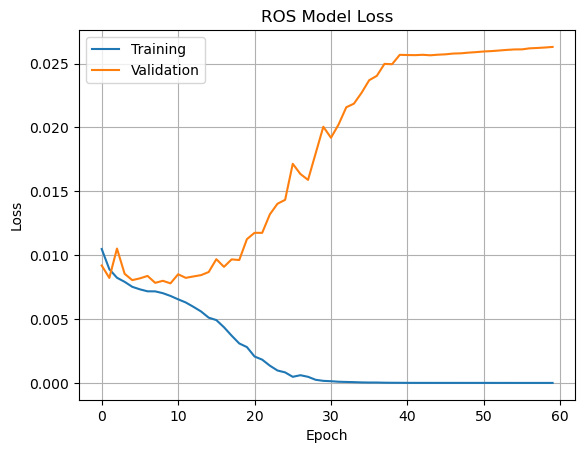

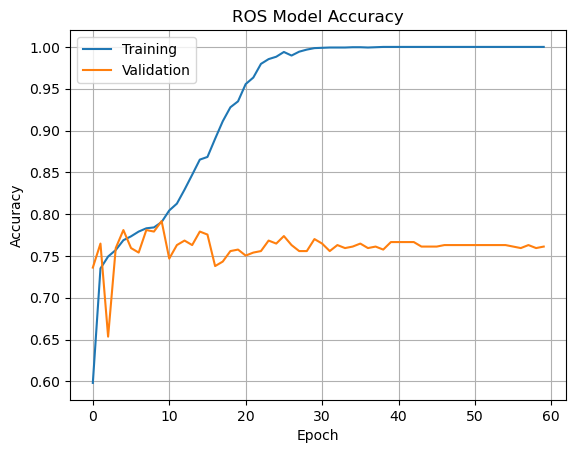

In [24]:
# Plot loss 
plt.figure()
plt.plot(range(n_epochs_CNN), train_loss_1, label='Training')
plt.plot(range(n_epochs_CNN), val_loss_1, label='Validation')
plt.title('ROS Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure()
plt.plot(range(n_epochs_CNN), train_accuracy_1, label='Training')
plt.plot(range(n_epochs_CNN), val_accuracy_1, label='Validation')
plt.title('ROS Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### F1 Score

This component presents the F1 score calculated on the validation set, providing a balanced measure of precision and recall. It evaluates the model’s ability to correctly identify crater and non-crater images while accounting for class imbalance.

In [ ]:
# Probabilities for the sample to belong to each class 
outputs = CNN_model(X_val_tensor)

# Obtain the most voted class for each sample  
_, y_predicted = torch.max(outputs, 1)

# Evaluate the performance giving the same importance to both labels
print("F1 score:", f1_score(y_val_tensor.numpy(), y_predicted.numpy(), average='macro'))  # .numpy() because f1_score expects an array instead of a tensor

F1 score: 0.7296783040088743


### Confusion Matrix

This section displays the confusion matrix for the ROS model, illustrating the distribution of correct and incorrect predictions per class.

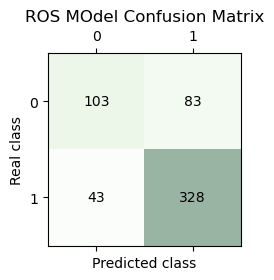

In [25]:
# Compute the confusion matrix
con_matrix = confusion_matrix(y_true=y_val_tensor, y_pred=y_predicted)

# Show the matrix 
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(con_matrix, cmap=plt.cm.Greens, alpha=0.4)

#Fill the matrix cells with their corresponding values
for i in range(con_matrix.shape[0]):
    for j in range(con_matrix.shape[1]):
        ax.text(x=j, y=i, s=con_matrix[i, j], va='center', ha='center')

plt.xlabel('Predicted class')
plt.ylabel('Real class')
plt.title('ROS MOdel Confusion Matrix')
plt.show()

## ROS Model with Extra Data 

This subsection summarizes the performance of the model retrained using the augmented dataset that includes high-confidence predictions from X_extra. The expanded dataset aims to provide more diverse and informative examples, potentially improving generalization.

### Performance Evolution

This component shows how the training and validation loss and accuracy evolve over epochs. The curves allow assessing whether the inclusion of extra data contributes to more stable or more effective learning dynamics.

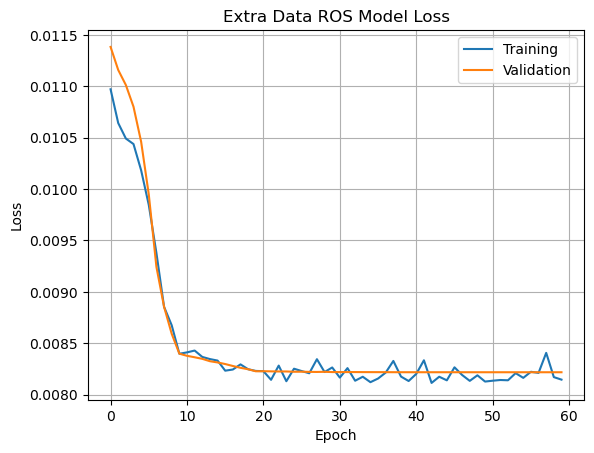

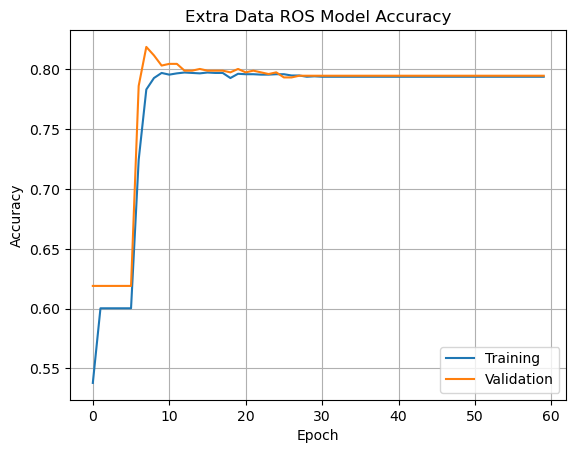

In [ ]:
# Plot loss 
plt.figure()
plt.plot(range(n_epochs_CNN_extra), train_loss_2, label='Training')
plt.plot(range(n_epochs_CNN_extra), val_loss_2, label='Validation')
plt.title('Extra Data ROS Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure()
plt.plot(range(n_epochs_CNN_extra), train_accuracy_2, label='Training')
plt.plot(range(n_epochs_CNN_extra), val_accuracy_2, label='Validation')
plt.title('Extra Data ROS Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

Incorporating the extra dataset improves the ROS model’s performance. The ROS model with extra data achieves higher accuracy and lower loss compared to the ROS model alone, demonstrating that additional high-confidence samples help the network learn more robust features and generalize better.

### F1 Score

This part reports the F1 score for the enhanced model, enabling direct comparison with the baseline ROS model and measuring the impact of incorporating additional pseudo-labeled samples.

In [ ]:
# Probabilities for the sample to belong to each class 
outputs = CNN_model(X_val_combined_tensor)

# Obtain the most voted class for each sample  
_, y_val_combined_predicted = torch.max(outputs, 1)

# Evaluate the performance giving the same importance to both labels
print("F1 score with extra data:", f1_score(y_val_combined_tensor.numpy(), y_val_combined_predicted.numpy(), average='macro'))

F1 score with extra data: 0.7787623050906065


The inclusion of extra data in the ROS model leads to an increase in the F1 score, reflecting a more effective trade-off between false positives and false negatives. This improvement shows that the model is better at correctly identifying both crater and non-crater images.

### Confusion Matrix

This section includes the confusion matrix for the model trained with extra data, facilitating analysis of classification improvements or remaining misclassification patterns when compared with the baseline model.

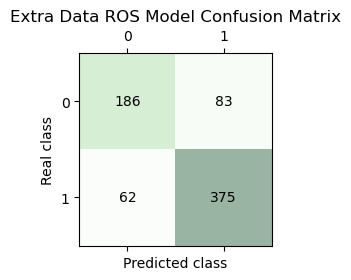

In [28]:
# Compute the confusion matrix
con_matrix = confusion_matrix(y_true=y_val_combined_tensor, y_pred=y_val_combined_predicted)

# Show the matrix 
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(con_matrix, cmap=plt.cm.Greens, alpha=0.4)

#Fill the matrix cells with their corresponding values
for i in range(con_matrix.shape[0]):
    for j in range(con_matrix.shape[1]):
        ax.text(x=j, y=i, s=con_matrix[i, j], va='center', ha='center')

plt.xlabel('Predicted class')
plt.ylabel('Real class')
plt.title('Extra Data ROS Model Confusion Matrix')
plt.show()

indicates a much stronger performance compared to the MLP model. The CNN correctly classified 186 true negatives (TN) and 375 true positives (TP), with only 83 false positives (FP) and 62 false negatives (FN). This shows a more accurate balance between classes and fewer misclassifications overall. Calculating from this matrix, the F1 score around 0.77 (macro), demonstrating that the CNN is significantly more effective at distinguishing between crater and non-crater images than the MLP. This highlights the advantage of using convolutional architectures for image classification tasks.

# Predictions on the Test Set

This section describes the procedure followed to generate final predictions on the unseen test dataset. Since this dataset does not include labels, only preprocessing, adaptation, and forward inference steps are performed. The goal is to apply the trained model to the test images in a consistent and reproducible way, producing reliable output classifications.

## Data Pre-Treatment

This subsection covers the initial preprocessing applied to the raw test images. The same operations used during training for binarization are applied here to ensure that the test data follow the same format and intensity distribution as the data used to train the model. This step guarantees fairness and consistency in the inference process.

In [ ]:
# Reshape the flat arrays into 48x48 pixel images
im = X_test.reshape(X_test.shape[0],48,48)

# Copy the images to a new array not to affect the original
new = im.copy()

# Binarize the images to facilitate the craters detection
for sample in range(im.shape[0]):

  # Outstanding boundaries
  for i in range(im.shape[1]):
      for j in range(im.shape[2]):
          if (im[sample][i][j] > upper_threshold) | (im[sample][i][j] < lower_threshold):
              new[sample][i][j] = 255
          else:
              new[sample][i][j] = 0

  # Removing isolated pixels
  for i in range(new.shape[1]):
      for j in range(new.shape[2]):
          if new[sample][i][j] == 255:
              if (i>0) and (j>0) and (i<new.shape[1]-1) and (j<new.shape[2]-1):
                  if ((new[sample][i-1][j]==0) and (new[sample][i+1][j]==0) and
                      (new[sample][i][j-1]==0) and (new[sample][i][j+1]==0) and
                      (new[sample][i-1][j-1]==0) and (new[sample][i-1][j+1]==0) and
                      (new[sample][i+1][j-1]==0) and (new[sample][i+1][j+1]==0)):

                        new[sample][i][j] = 0

## Data Adaptation

This part describes the transformation of the preprocessed images into the final format required by the CNN. The images are reshaped, normalized, converted into tensors, and expanded with the appropriate channel dimension.

In [ ]:
# Copy the processed images to a new array not to affect the original
X_test_processed = new.copy()

# Normalize images (Tensors only admit normalized float data)
X_test_normalized = (X_test_processed / 255.0).astype(np.float32)  

# Convert images matrixes into tensors  
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)

# Increase the rank of the tensor (dimension) to use the number of channels as input of the CNN
X_test_tensor = X_test_tensor.unsqueeze(1) 

## Prediction

This subsection details the inference stage, where the adapted test images are passed through the trained CNN to generate predicted class labels. Gradient computation is disabled to optimize performance, and the model outputs are converted into final discrete predictions. These predictions represent the network’s final assessment of the presence or absence of craters in each test image.

In [ ]:
# Disable gradients for inference to save memory and computational time
with torch.no_grad():

    # Probabilities for the sample to belong to each class 
    outputs = CNN_model(X_test_tensor)

    # Obtain the most voted class for each sample  
    _, y_test_tensor = torch.max(outputs, 1)

    # Convert from tensor to array 
    y_test_np = y_test_tensor.numpy()

    # Save test predicted labels into a .npy file
    np.save('y_test', y_test_np)